In [5]:
# Import necessary libraries for managing datasets, image processing, and modeling.

# Datasets and XML parsing
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import h5py

# Image preprocessing
from skimage import feature
import skimage
from sklearn.feature_extraction.image import extract_patches_2d
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw, ImageFont
import imgaug.augmenters as iaa
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize, pyramid_gaussian

#Generic libraries
import numpy as np
import matplotlib.pyplot as plt
import argparse
import random
import os

# Model & Training
from sklearn.svm import SVC
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

#### Here we define some paths to jpeg and xml files

*for generate xml with all information about class and boxes coordinates LabelImg where used*

In [49]:
all_jpeg = glob.glob('cumulative_jpeg/'+'*.jpeg')
all_xml = glob.glob('cumulative_xml/'+'*.xml')
not_faces = glob.glob('negative_jpeg/'+'*.jpeg')

In [18]:
# Iterate through all XML files and build a tree object for each one.
# The last tree object in the loop will be the one retained.
for t in all_xml:
    tree = ET.parse(t)

# Get the root element of the tree, which represents the top-level element in the XML file.
root = tree.getroot()

# Print the XML tree (this will display the tree's root element and its structure).
print(tree)

# Initialize an empty list to store the tags present in the XML files.
child_tags = []

# Iterate through the children of the root element and extract their tag names.
# Append these tag names to the child_tags list.
for child in root:
    childtag = child.tag
    child_tags.append(childtag)

# Print the list of extracted child tags from the XML files.
print(child_tags)

['folder', 'filename', 'path', 'source', 'size', 'segmented', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object']


In [19]:
# Iterate through the elements within the "size" tag.
# This tag often contains information about the width and height of the images.
for s in root.find('size'):
    # Print the individual elements within the "size" tag.
    print(s)

<Element 'width' at 0x12fa09d60>
<Element 'height' at 0x12fa09d10>
<Element 'depth' at 0x12fa09cc0>


#### With this code we can extract bouding boxes coordinates from the xml files

In [20]:
def extract_bounding_boxes(xml_files):
    bounding_boxes = []

    for t in xml_files:
        tree = ET.parse(t)
        root = tree.getroot()

        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bounding_box_info = {'name': name, 'xmin': xmin,
                                 'ymin': ymin, 'xmax': xmax,
                                 'ymax': ymax}
            bounding_boxes.append(bounding_box_info)

    return bounding_boxes

# Call the function with list of XML files
bounding_boxes = extract_bounding_boxes(all_xml)

# Print the extracted bounding box information as an example to show how it works
for index, box in enumerate(bounding_boxes[:2], start=1):
    print(f"Bounding Box {index} - Object: {box['name']}")
    print(f"xmin: {box['xmin']}, ymin: {box['ymin']}, xmax: {box['xmax']}, ymax: {box['ymax']}")

Bounding Box 1 - Object: face
xmin: 15, ymin: 14, xmax: 79, ymax: 72
Bounding Box 2 - Object: face
xmin: 55, ymin: 55, xmax: 98, ymax: 108


##### Here we generate a dataframe with the most important information

In [23]:
def df_from_xml(xml_path):
    """
    Generates a DataFrame from XML files containing object and bounding box information.

    Args:
        xml_path (str): Path to the directory containing XML files.

    Returns:
        pd.DataFrame: DataFrame containing object and bounding box information.
    """

    xml_list = []
    # Iterate through XML files in the specified directory
    for x_file in all_xml:
        tree = ET.parse(x_file)
        root = tree.getroot()
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)

        # Iterate through bounding boxes in the XML file
        for bb in root.findall('object'):
            bndbox = bb.find('bndbox')
            value = (
                filename,
                width,
                height,
                bb.find('name').text,
                int(bndbox.find('xmin').text),
                int(bndbox.find('ymin').text),
                int(bndbox.find('xmax').text),
                int(bndbox.find('ymax').text)
            )
            xml_list.append(value)

    # Create a DataFrame from the collected information
    column_names = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    dataset = pd.DataFrame(xml_list, columns=column_names)
    return dataset

#### A little bit of exploration of the dataset

In [25]:
dataset = df_from_xml(all_xml)

In [27]:
dataset.to_csv('faces.csv',index=False)

In [31]:
dataset['class'].value_counts()

class
face    242
Name: count, dtype: int64

In [32]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  242 non-null    object
 1   width     242 non-null    int64 
 2   height    242 non-null    int64 
 3   class     242 non-null    object
 4   xmin      242 non-null    int64 
 5   ymin      242 non-null    int64 
 6   xmax      242 non-null    int64 
 7   ymax      242 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 15.2+ KB


In [33]:
dataset.describe()

,width,height,xmin,ymin,xmax,ymax
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,259.318182,181.033058,109.574380,56.016529,149.132231,98.128099
std,76.906704,43.535827,68.676376,41.890290,79.294916,53.956992
min,100.000000,100.000000,1.000000,3.000000,18.000000,20.000000
25%,225.000000,168.000000,59.000000,25.500000,88.000000,61.000000
50%,275.000000,181.000000,101.000000,48.000000,146.000000,88.000000
75%,300.000000,194.000000,154.250000,65.000000,201.000000,130.750000
max,1024.000000,575.000000,386.000000,225.000000,704.000000,575.000000


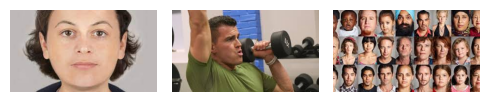

In [48]:

num_images = 3  # Number of images to display
fig, axes = plt.subplots(1, num_images, figsize=(5, 5))

# Iterate through a subset of image files (adjust the range as needed)
for i, img_path in enumerate(all_jpeg[:num_images]):
    # Read the image using imread
    img = imread(img_path)
    
    # Display the image in the corresponding subplot
    axes[i].imshow(img)
    axes[i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

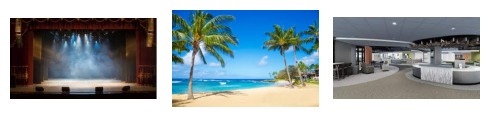

In [52]:
num_images = 3  # Number of images to display
fig, axes = plt.subplots(1, num_images, figsize=(5, 5))

# Iterate through a subset of image files (adjust the range as needed)
for i, img_path in enumerate(not_faces[:num_images]):
    # Read the image using imread
    img = imread(img_path)
    
    # Display the image in the corresponding subplot
    axes[i].imshow(img)
    axes[i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### Using the mean of the x and y of bounding boxes we can get a good approximation for a possible sliding window dimension.
*Ceil function is used to round up to the first integer*

In [53]:
# Calculate the average width and height of bounding boxes labeled as "face" in the dataset
# This can be used as a window sliding dimension for face detection
xdim = np.ceil(np.mean(dataset[dataset['class'] == 'face']['xmax'] - dataset[dataset['class'] == 'face']['xmin']))
ydim = np.ceil(np.mean(dataset[dataset['class'] == 'face']['ymax'] - dataset[dataset['class'] == 'face']['ymin']))

In [54]:
print(xdim,ydim)

40.0 43.0


#### Here start the functions used to manipulate images

In [55]:
def hogFeatures(image, orientations = 12, pixelsPerCell = (8,8), cellsPerBlock = (2,2), channel_axis=-1):
    """
    Extract HOG features from an image and set negative values to 0.

    Args:
        image (ndarray): The input image.
        orientations (int): Number of bins in the histogram.
        pixelsPerCell (tuple): Number of pixels per cell.
        cellsPerBlock (tuple): Number of cells per block.
        channel_axis (int, optional): Axis representing color channels.

    Returns:
        ndarray: Extracted HOG features.
    """
    # Extract HOG features from the image
    features = feature.hog(image,
                           orientations=orientations,
                           pixels_per_cell=pixelsPerCell,
                           cells_per_block=cellsPerBlock,
                           transform_sqrt=True,
                           channel_axis=channel_axis)
    
    # Set any negative values to 0
    features[features < 0] = 0
    
    return features

In [56]:
def img_aug(roi, width, height, extension=True):
    """
    Perform image augmentation on a region of interest (ROI).

    Args:
        roi (PIL.Image): The region of interest image.
        width (int): The target width after resizing.
        height (int): The target height after resizing.
        extension (bool, optional): Flag indicating whether to apply extended augmentation.

    Returns:
        list: List of augmented region of interest images.
    """
    region_interests = []

    # Resize the ROI image to the specified width and height
    roi_resized = roi.copy().resize((width, height), Image.BICUBIC)
    region_interests.append(roi_resized)

    if extension:
        # Apply rotations and filters for augmentation
        transformations = [30, 60, 90, 120, 150]
        for transf in transformations:
            rotation = roi_resized.rotate(transf)
            region_interests.append(rotation)

        sharpness = ImageEnhance.Sharpness(roi_resized)
        contrast = ImageEnhance.Contrast(roi_resized)

        # Additional augmentation transformations
        region_interests.append(roi_resized.filter(ImageFilter.EDGE_ENHANCE))
        region_interests.append(sharpness.enhance(5))
        region_interests.append(contrast.enhance(5.0))

    return region_interests